In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train_features_df = pd.read_csv("train_features.csv")
train_labels_df = pd.read_csv("train_salaries.csv")
test_features_df = pd.read_csv("test_features.csv")

In [5]:
train_features_df.shape, train_labels_df.shape, test_features_df.shape

((1000000, 8), (1000000, 2), (1000000, 8))

In [6]:
train_df = pd.merge(train_features_df, train_labels_df, on='jobId')

train_df.shape

(1000000, 9)

In [7]:
train_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

In [8]:
test_features_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

### Concatenate test and train dataframes to apply same operations/transformations on them

In [9]:
train_df["Type"] = "TRAIN"

test_features_df["salary"] = 0
test_features_df["Type"] = "TEST"

train_df.shape, test_features_df.shape

((1000000, 10), (1000000, 10))

In [10]:
train_df.columns, test_features_df.columns

(Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
        'yearsExperience', 'milesFromMetropolis', 'salary', 'Type'],
       dtype='object'),
 Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
        'yearsExperience', 'milesFromMetropolis', 'salary', 'Type'],
       dtype='object'))

In [11]:
concat_df = pd.concat([train_df, test_features_df])

concat_df.shape

(2000000, 10)

### Create one-hot vectors for categorical variables

In [12]:
categorical_variables = ['jobType', 'degree', 'major', 'industry']

expanded_df = pd.get_dummies(concat_df, columns=categorical_variables)

In [13]:
expanded_df.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,Type,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,COMP37,10,83,130,TRAIN,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,JOB1362684407688,COMP19,3,73,101,TRAIN,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,JOB1362684407689,COMP52,10,38,137,TRAIN,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,JOB1362684407690,COMP38,8,17,142,TRAIN,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,COMP7,8,16,163,TRAIN,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [14]:
expanded_df.columns

Index(['jobId', 'companyId', 'yearsExperience', 'milesFromMetropolis',
       'salary', 'Type', 'jobType_CEO', 'jobType_CFO', 'jobType_CTO',
       'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELORS',
       'degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
       'degree_NONE', 'major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY',
       'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
       'major_NONE', 'major_PHYSICS', 'industry_AUTO', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB'],
      dtype='object')

In [15]:
transformed_train_df = expanded_df[expanded_df['Type'] == 'TRAIN']
transformed_test_df = expanded_df[expanded_df['Type'] == 'TEST']

assert transformed_train_df.shape == transformed_test_df.shape

### Prepare data for training

In [16]:
target = transformed_train_df['salary']

transformed_train_df.drop(['jobId', 'companyId', 'salary', 'Type',], axis=1, inplace=True)

transformed_test_df.drop(['jobId', 'companyId', 'salary', 'Type',], axis=1, inplace=True)

C:\ProgramData\Anaconda3\envs\arcgis183\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
target.shape, transformed_train_df.shape

((1000000,), (1000000, 31))

In [18]:
assert transformed_test_df.shape == transformed_train_df.shape

### Model Training

In [19]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import backend

Using TensorFlow backend.


In [20]:
checkpoint = ModelCheckpoint(filepath='salary_predictor.h5', verbose=1, save_best_only=True)

In [21]:
model = Sequential()
model.add(Dense(32, input_shape=(31,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

In [22]:
def rmse(y_true, y_pred):
    return backend.sqrt(metrics.mean_squared_error(y_true, y_pred))

In [23]:
model.compile(loss=rmse, optimizer='adam', metrics=[metrics.mae, metrics.mean_squared_logarithmic_error])

In [24]:
history = model.fit(transformed_train_df, target, epochs=10, batch_size=128,
                    verbose=1, callbacks=[checkpoint], validation_split=0.1)

Train on 900000 samples, validate on 100000 samples
Epoch 1/10
900000/900000 [==============================] - 56s 63us/step - loss: 37.3226 - mean_absolute_error: 37.3226 - mean_squared_logarithmic_error: 1.5292 - val_loss: 15.7068 - val_mean_absolute_error: 15.7068 - val_mean_squared_logarithmic_error: 0.0268

Epoch 00001: val_loss improved from inf to 15.70684, saving model to salary_predictor.h5
Epoch 2/10
900000/900000 [==============================] - 58s 64us/step - loss: 16.1311 - mean_absolute_error: 16.1311 - mean_squared_logarithmic_error: 0.0291 - val_loss: 15.5487 - val_mean_absolute_error: 15.5487 - val_mean_squared_logarithmic_error: 0.0258

Epoch 00002: val_loss improved from 15.70684 to 15.54870, saving model to salary_predictor.h5
Epoch 3/10
900000/900000 [==============================] - 56s 62us/step - loss: 16.0670 - mean_absolute_error: 16.0670 - mean_squared_logarithmic_error: 0.0287 - val_loss: 15.8018 - val_mean_absolute_error: 15.8018 - val_mean_squared_log

In [25]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error', 'loss', 'mean_absolute_error', 'mean_squared_logarithmic_error'])

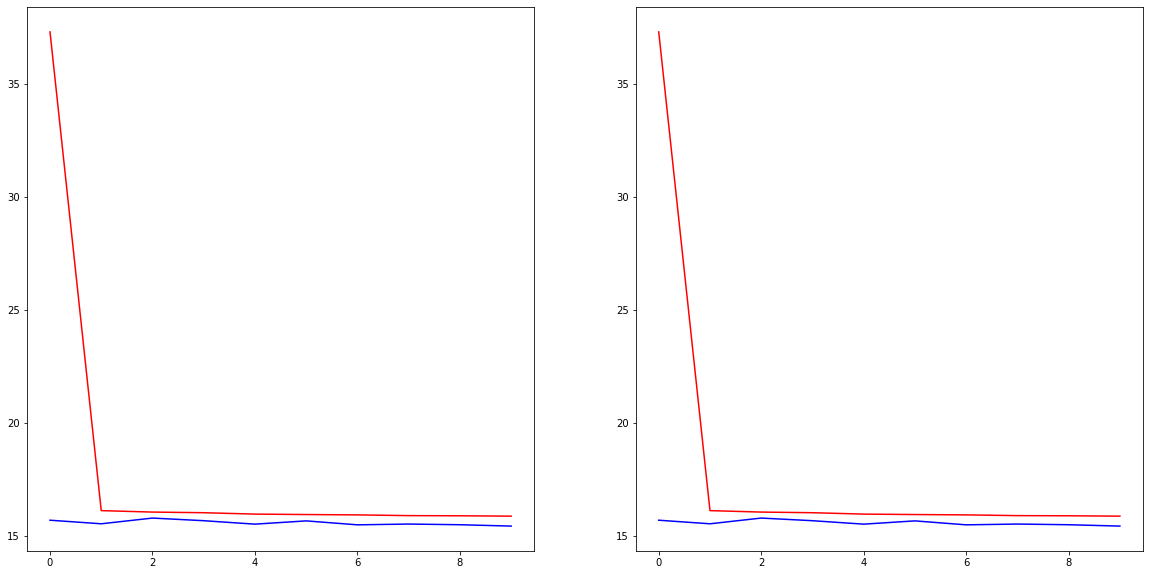

In [26]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['mean_absolute_error'], color='r')
ax2.plot(history.history['val_mean_absolute_error'], color='b')

## Get Predictions

In [27]:
from keras.models import load_model

model = load_model('salary_predictor.h5', custom_objects={'rmse': rmse})

In [28]:
transformed_test_df.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,22,73,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,20,47,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,17,9,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,14,96,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,10,44,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Type
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,0,TEST
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,0,TEST
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,0,TEST
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,0,TEST
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,0,TEST


In [30]:
assert transformed_test_df.shape[0] == test_features_df.shape[0]

In [31]:
pred = model.predict(transformed_test_df)

In [32]:
submission = pd.DataFrame()
submission['jobId'] = test_features_df['jobId']
submission['salary'] = pred

In [33]:
submission.shape

(1000000, 2)

In [34]:
submission.head()

,jobId,salary
0,JOB1362685407687,106.784843
1,JOB1362685407688,90.774323
2,JOB1362685407689,171.558868
3,JOB1362685407690,100.886414
4,JOB1362685407691,114.530289


In [35]:
submission.to_csv('test_salaries.csv', index=False)